Task 2: Import Necessary Packages

In [0]:
!pip3 install pandas
!pip3 install tensorflow 
!pip3 install -q seaborn
%tensorflow_version 1.x
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
import io
from google.colab import files
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

Task 3: Print Tensorflow version

In [0]:
print(tf.__version__)

1.15.0


Task 4: Upload data to Colab

In [0]:
from google.colab import files
uploaded = files.upload()

Saving qsar_fish_toxicity.csv to qsar_fish_toxicity.csv


Task 5: Display Dataset Tail

In [0]:
dataset = pd.read_csv('/content/qsar_fish_toxicity.csv',sep=';',names=["CIC0","SM1_Dz(Z)","GATS1i","NdsCH","NdssC","MLOGP","Quantitative response, LC50 [-LOG(mol/L)"])
dataset.tail()

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,"Quantitative response, LC50 [-LOG(mol/L)"
904,2.801,0.728,2.226,0,2.0,0.736,3.109
905,3.652,0.872,0.867,2,3.0,3.983,4.040
906,3.763,0.916,0.878,0,6.0,2.918,4.818
907,2.831,1.393,1.077,0,1.0,0.906,5.317
908,4.057,1.032,1.183,1,3.0,4.754,8.201


#Task 6: Clean Data Set

In [0]:
rowindex = 0
totalrowstodelete = 0
# find which rows to delete along with total count of rows to delete
for index, row in dataset.iterrows():
  rowisnull = row.isnull().any()
  if (rowisnull):
    print("row", rowindex, "has a NaN value")
    totalrowstodelete = totalrowstodelete + 1
  rowindex = rowindex + 1
print("In total we must delete", totalrowstodelete, "rows")
dataset = dataset.reset_index(drop=True)
# find number of NA data for each category
dataset.isna().sum()


row 114 has a NaN value
row 149 has a NaN value
row 609 has a NaN value
row 760 has a NaN value
In total we must delete 4 rows


,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,"Quantitative response, LC50 [-LOG(mol/L)"
0,3.260,0.829,1.676,0,1.0,1.453,3.770
1,2.189,0.580,0.863,0,0.0,1.348,3.115
2,2.125,0.638,0.831,0,0.0,1.348,3.531
3,3.027,0.331,1.472,1,0.0,1.807,3.510
4,2.094,0.827,0.860,0,0.0,1.886,5.390


In [0]:
dataset = dataset.dropna()

Task 7: Choosing training data

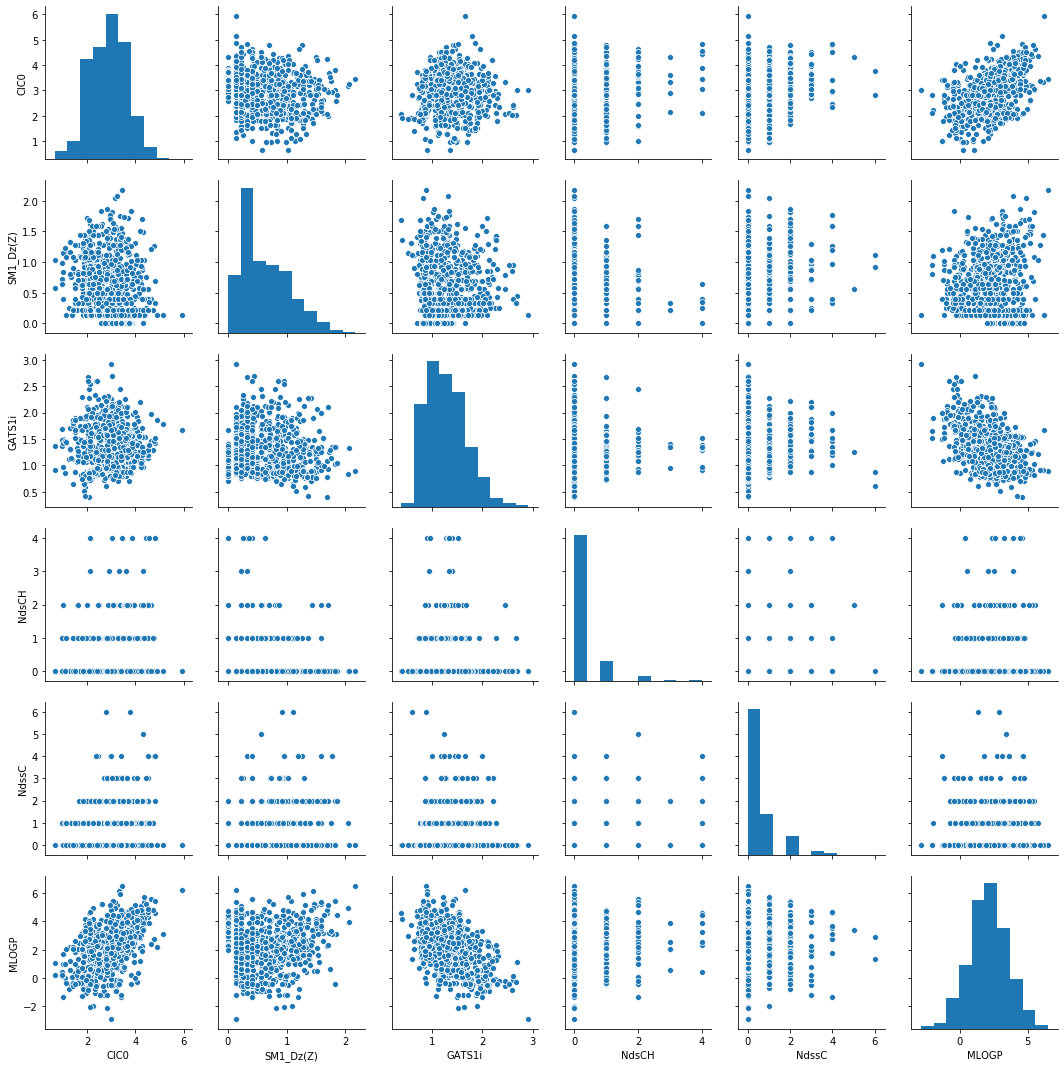

In [0]:
#training and testing data ratios
tDataRatio = 0.85
TestDataRatio = 1 - tDataRatio
trainLength = int(905*tDataRatio)
trainDataIndices = np.arange(trainLength)
testDataIndices = np.arange(905)
#randomly choose indices to add to training data and remove from test indices
for i in range (0, trainLength):
  index = rd.choice(testDataIndices)
  testDataIndices = testDataIndices[testDataIndices != index]
  trainDataIndices[i] = index

#create training and testing pandas datasets
trainDataSet = dataset[:trainLength].copy()
for i in range(trainLength):
  trainDataSet.loc[i] = dataset.loc[trainDataIndices[i]]

testDataSet = dataset[:(905-trainLength)].copy()
for i in range(905-trainLength):
  testDataSet.loc[i] = dataset.loc[testDataIndices[i]]
#seaborn pair plot
sns.pairplot(dataset[["CIC0","SM1_Dz(Z)","GATS1i","NdsCH","NdssC","MLOGP"]])

The histograms will tell us the distribution of each variable. The scatter plots can tell us how each variable is correlated with all of the other variables. Most of the scatter plots seem to be extremely random with little to no correlation. A few of them seem to have a very slight positive or negative correlation. Some of the plots suggest that data towards the median will have a higher average average value of that variable. Plotting NdssC vs GATSli demonstrates this tendency. 

Task 8: Statistics

In [0]:
statsMatrix = zeros = [ [0] * 8 for _ in range(6)]
columnlabels = ["CIC0","SM1_Dz(Z)","GATS1i","NdsCH","NdssC","MLOGP"]
for i in range(6): # get stats data for each toxicity data
  # get count -> same for all;
  statsMatrix[i][0] = trainDataSet.shape[0]
  # get mean
  statsMatrix[i][1] = trainDataSet.mean(axis=0)[i]
  # get standard deviation
  statsMatrix[i][2] = trainDataSet.std(axis=0)[i]
  # get minimum
  statsMatrix[i][3] = trainDataSet.min(axis=0)[i]
  # get 25% value
  statsMatrix[i][4] = trainDataSet.quantile(q=0.25,axis=0)[i]
  # get 50% value
  statsMatrix[i][5] = trainDataSet.median(axis=0)[i]
  # get 75% value
  statsMatrix[i][6] = trainDataSet.quantile(q=0.75,axis=0)[i]
  # get maximum
  statsMatrix[i][7] = trainDataSet.max(axis=0)[i]
statsdata = pd.DataFrame(statsMatrix, index = ["CIC0","SM1_Dz(Z)","GATS1i","NdsCH","NdssC","MLOGP"],
                  columns =["count", "mean", "standard deviation", "minimum data", "25% value", "50% value", "75% value", "maximum data"]) 
statsdata


,count,mean,standard deviation,minimum data,25% value,50% value,75% value,maximum data
CIC0,769,2.891687,0.760376,0.667,2.344,2.878,3.407,5.926
SM1_Dz(Z),769,0.623391,0.426645,0.000,0.223,0.570,0.887,2.171
GATS1i,769,1.292538,0.395780,0.396,0.950,1.244,1.562,2.920
NdsCH,769,0.235371,0.608531,0.000,0.000,0.000,0.000,4.000
NdssC,769,0.498049,0.872203,0.000,0.000,0.000,1.000,6.000
MLOGP,769,2.072497,1.406189,-2.884,1.182,2.102,3.018,6.515


Task 9: 

In [0]:
normalizedTrainDataSet = trainDataSet.copy()
normalizedTestDataSet = testDataSet.copy()
#set training data equal to normalized values calculated in previous cell for all values except column to be predicted
for i in range(trainLength):
  for j in range(6):
    normalValue = (trainDataSet.loc[i][columnlabels[j]] - statsMatrix[j][1]) / statsMatrix[j][2]
    normalizedTrainDataSet.set_value(i, columnlabels[j], normalValue)
#set testing data equal to normalized values calculated in previous cell for all values except column to be predicted
for i in range(905 - trainLength):
  for j in range(6):
    normalValue = (testDataSet.loc[i][columnlabels[j]] - statsMatrix[j][1]) / statsMatrix[j][2]
    normalizedTestDataSet.set_value(i, columnlabels[j], normalValue)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


Task 10: creating a neural network

In [0]:
#Creates neural network with 64 neurons and relu activation function in each hidden layer 
model = Sequential()
model.add(Dense(64, input_dim=6, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
#use metrics of mean absolute error and mean squared error
model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mean_absolute_error','mean_squared_error'])




```
# This is formatted as code
```

Task 11: Test untrained model

In [0]:
#convert pandas arrays to numpy arrays and separte into input data and output column to be predicted
numpTrainData = normalizedTrainDataSet.rename_axis('ID').values
input1 = numpTrainData[:, 0:6]
output1 = numpTrainData[:, 6]

numpTestData = normalizedTestDataSet.rename_axis('ID').values
input2 = numpTestData[:, 0:6]
output2 = numpTestData[:, 6]
#test untrained model for 10 predictions
predictions = model.predict(input1[:10])
for i in range(10):
  print(predictions[i],output1[i])


[0.22197708] 4.54
[0.01489136] 3.661
[-0.2961017] 4.796
[0.05176634] 4.208
[0.07717308] 2.94
[-0.04384115] 4.215
[0.02304643] 2.4130000000000003
[-0.00885759] 5.005
[-0.14196447] 5.052
[-0.36299086] 1.18


After one pass, the accuracy is extremely low. The predicted values are not even close. This is probably because the model 

Task 12: Training for 1000 epochs

In [0]:
history1 = model.fit(input1, output1, validation_split = 15.0/85.0, epochs=1000, batch_size=32)

Train on 633 samples, validate on 136 samples
Epoch 1/1000
633/633 [==============================] - 1s 2ms/step - loss: 14.7746 - mean_absolute_error: 3.5829 - mean_squared_error: 14.7746 - val_loss: 11.9528 - val_mean_absolute_error: 3.1489 - val_mean_squared_error: 11.9528
Epoch 2/1000
633/633 [==============================] - 0s 73us/step - loss: 7.4443 - mean_absolute_error: 2.4111 - mean_squared_error: 7.4443 - val_loss: 5.3162 - val_mean_absolute_error: 2.0221 - val_mean_squared_error: 5.3162
Epoch 3/1000
633/633 [==============================] - 0s 66us/step - loss: 3.0369 - mean_absolute_error: 1.4253 - mean_squared_error: 3.0369 - val_loss: 2.2346 - val_mean_absolute_error: 1.1923 - val_mean_squared_error: 2.2346
Epoch 4/1000
633/633 [==============================] - 0s 63us/step - loss: 1.8351 - mean_absolute_error: 1.0285 - mean_squared_error: 1.8351 - val_loss: 1.7071 - val_mean_absolute_error: 1.0187 - val_mean_squared_error: 1.7071
Epoch 5/1000
633/633 [=============

In [0]:
df = pd.DataFrame(history1.history) 
df.head()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error
0,11.952786,3.148940,11.952786,14.774607,3.582922,14.774607
1,5.316220,2.022086,5.316220,7.444338,2.411097,7.444338
2,2.234585,1.192329,2.234585,3.036930,1.425303,3.036930
3,1.707140,1.018686,1.707140,1.835075,1.028534,1.835075
4,1.701202,1.013484,1.701202,1.553798,0.944518,1.553798


In [0]:
df.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error
995,1.019644,0.726369,1.019644,0.078833,0.203274,0.078833
996,0.980552,0.714823,0.980552,0.084549,0.215488,0.084549
997,1.047141,0.732034,1.047141,0.076407,0.202535,0.076407
998,0.979166,0.720211,0.979166,0.081809,0.210449,0.081809
999,1.017243,0.722313,1.017243,0.074575,0.199148,0.074575


Task 14: Plotting accuracy of model

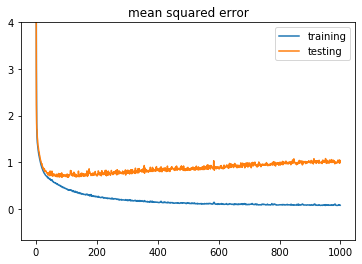

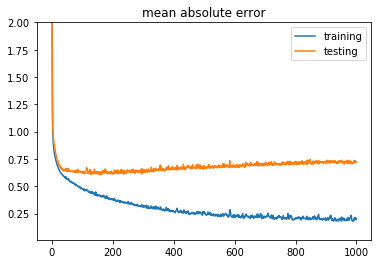

In [0]:
#mean squared error of model for training and validation data
plt.figure(1)
plt.plot(history1.history['mean_squared_error'], label = 'training')
plt.plot(history1.history['val_mean_squared_error'],label = 'testing')
plt.ylim(top=4)
plt.legend()
plt.title('mean squared error')
plt.show()

#mean absolute error of model for training and validation data
plt.figure(2)
plt.plot(history1.history['mean_absolute_error'], label = 'training')
plt.plot(history1.history['val_mean_absolute_error'],label = 'testing')
plt.ylim(top=2)
plt.legend()
plt.title('mean absolute error')
plt.show()

In [0]:
#creates new model to be trained until the accuracy is sufficient
models = Sequential()
models.add(Dense(64, input_dim=6, activation='relu'))
models.add(Dense(64, activation='relu'))
models.add(Dense(1))
models.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mean_absolute_error','mean_squared_error'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# This callback will stop the training when there is no improvement in
# the validation loss for 10 consecutive epochs.
history2 = models.fit(input1, output1, epochs=1000, callbacks=[callback], validation_split=15.0/85.0)

Train on 633 samples, validate on 136 samples
Epoch 1/1000
633/633 [==============================] - 2s 3ms/step - loss: 14.2954 - mean_absolute_error: 3.4886 - mean_squared_error: 14.2954 - val_loss: 11.3023 - val_mean_absolute_error: 3.0588 - val_mean_squared_error: 11.3023
Epoch 2/1000
633/633 [==============================] - 0s 62us/step - loss: 6.6903 - mean_absolute_error: 2.2765 - mean_squared_error: 6.6903 - val_loss: 4.4906 - val_mean_absolute_error: 1.8793 - val_mean_squared_error: 4.4906
Epoch 3/1000
633/633 [==============================] - 0s 58us/step - loss: 2.7681 - mean_absolute_error: 1.3444 - mean_squared_error: 2.7681 - val_loss: 1.9552 - val_mean_absolute_error: 1.1401 - val_mean_squared_error: 1.9552
Epoch 4/1000
633/633 [==============================] - 0s 50us/step - loss: 1.8685 - mean_absolute_error: 1.0289 - mean_squared_error: 1.8685 - val_loss: 1.6974 - val_mean_absolute_error: 1.0357 - val_mean_squared_error: 1.6974
Epoch 5/1000
633/633 [=============

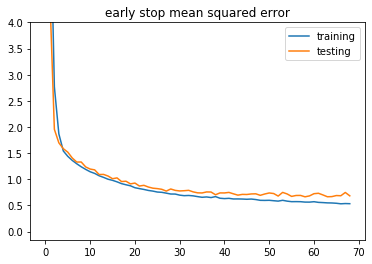

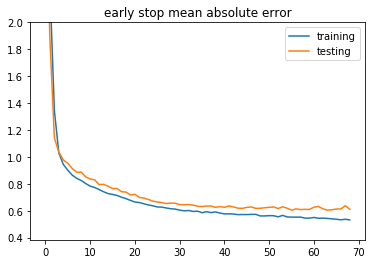

In [0]:
#mean squared error for early stop model 
plt.figure(1)
plt.plot(history2.history['mean_squared_error'], label = 'training')
plt.plot(history2.history['val_mean_squared_error'],label = 'testing')
plt.ylim(top=4)
plt.legend()
plt.title('early stop mean squared error')
plt.show()

#mean absolute error for early stop model 
plt.figure(2)
plt.plot(history2.history['mean_absolute_error'], label = 'training')
plt.plot(history2.history['val_mean_absolute_error'],label = 'testing')
plt.ylim(top=2)
plt.legend()
plt.title('early stop mean absolute error')
plt.show()

Task 15: Testing model

In [0]:
#evaluate model with testing data
scores = model.evaluate(input2, output2)
print("the loss is ", scores[0])
print("the mean absolute error is ", scores[1])
print("the mean squared error is ", scores[2])

136/136 [==============================] - 0s 79us/step
the loss is  1.4657805667204016
the mean absolute error is  0.8589996660456938
the mean squared error is  1.4657805667204016


Task 16: Predict LC50 values 

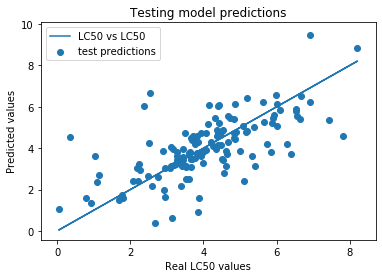

In [0]:
#test model by predicting LC50 output values
#flatten so that it can be plotted and histogrammed
predictions = model.predict(input2).flatten()
plt.figure(3)
#plot LC50 against itself for a standard 
plt.plot(output2, output2, label = 'LC50 vs LC50')
#plots predictions against real LC50 values
plt.scatter(output2, predictions, label ='test predictions')
plt.xlabel('Real LC50 values')
plt.ylabel('Predicted values')
plt.title('Testing model predictions')
plt.legend()
plt.show()

Task 17: Histogram of prediction error

Text(0, 0.5, 'Count')

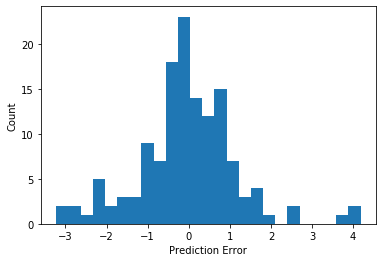

In [0]:
#errors in model prediction
error = predictions - output2
plt.hist(error, bins=25)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
